Trade Entry: 213.9 | Timestamp: 2025-01-06 08:30:00+00:00  | Take Proft: 209.84857142857143 | Stop Loss: 217.14114285714285  |  PnL: $-20.00  |  Equity: $980.00 | Volume: 9543
🔴Trade closed: 2025-01-06 12:15:00+00:00 | Stop Loss hit: 2025-01-06 12:15:00+00:00 | Exit: 216.98 | SL: 217.14114285714285
Trade Entry: 196.0 | Timestamp: 2025-01-08 11:15:00+00:00  | Take Proft: 192.4257142857143 | Stop Loss: 198.85942857142857  |  PnL: $-19.60  |  Equity: $960.40 | Volume: 33609
🔴Trade closed: 2025-01-08 14:30:00+00:00 | Stop Loss hit: 2025-01-08 14:30:00+00:00 | Exit: 197.86 | SL: 198.85942857142857
Trade Entry: 187.28 | Timestamp: 2025-01-09 17:45:00+00:00  | Take Proft: 181.17714285714285 | Stop Loss: 192.1622857142857  |  PnL: $-19.21  |  Equity: $941.19 | Volume: 14726
🔴Trade closed: 2025-01-10 07:30:00+00:00 | Stop Loss hit: 2025-01-10 07:30:00+00:00 | Exit: 192.66 | SL: 192.1622857142857
Trade Entry: 185.79 | Timestamp: 2025-01-11 07:15:00+00:00  | Take Proft: 182.64142857142855 | Stop 

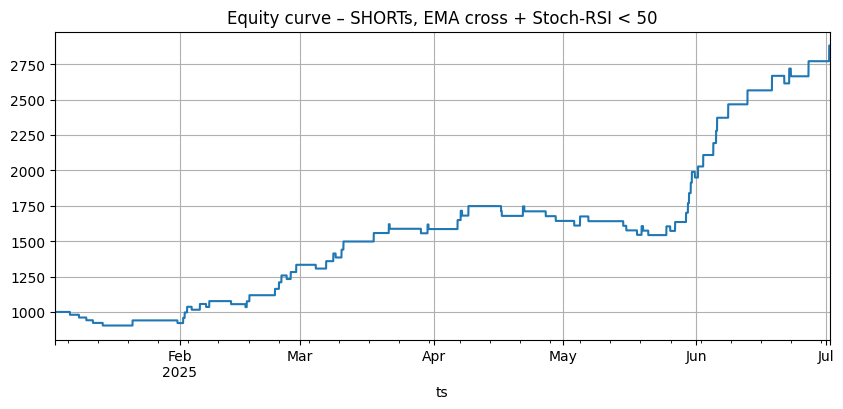

In [23]:
# pip install ccxt pandas numpy matplotlib ta
import ccxt, ta, pandas as pd, numpy as np, matplotlib.pyplot as plt

# ───────────────── CONFIG ──────────────────────────────────────────
PAIR, TF, LOOKBACK_D = "SOL/USDT", "15m", 180          # 30 days history
RISK_PCT     = 0.02                                   # 2 % of equity
ATR_MULT_SL  = 2.0                                    # stop  = 2×ATR
ATR_MULT_TP  = 4.0                                    # target= 4×ATR (RR 2:1)
ADX_FLOOR    = 20                                     # must be trending
GOOD_HOURS   = set(range(14, 23))                     # optional UTC window

# ───────────────── DOWNLOAD DATA ───────────────────────────────────
ex, rows = ccxt.bybit(), []
since = ex.milliseconds() - LOOKBACK_D * 86_400_000
while since < ex.milliseconds():
    chunk = ex.fetch_ohlcv(PAIR, TF, since=since, limit=1000)
    if not chunk: break
    rows.extend(chunk); since = chunk[-1][0] + 1

df = (pd.DataFrame(rows, columns="ts o h l c v".split())
        .assign(ts=lambda d: pd.to_datetime(d.ts, unit="ms", utc=True))
        .set_index("ts"))

# ───────────────── INDICATORS ──────────────────────────────────────
df["ema7"]   = df.c.ewm(span=7).mean()
df["ema14"]  = df.c.ewm(span=14).mean()
df["ema28"]  = df.c.ewm(span=28).mean()

tr = np.maximum.reduce([df.h-df.l,
                        (df.h-df.c.shift()).abs(),
                        (df.l-df.c.shift()).abs()])
df["atr"] = pd.Series(tr, index=df.index).rolling(14).mean()

# RSI & Stoch-RSI
delta = df.c.diff()
gain  = delta.clip(lower=0).ewm(alpha=1/14, adjust=False).mean()
loss  = (-delta.clip(upper=0)).ewm(alpha=1/14, adjust=False).mean()
rs    = gain / loss
df["rsi"] = 100 - 100 / (1 + rs)

rsi_min = df.rsi.rolling(14).min()
rsi_max = df.rsi.rolling(14).max()
stoch_rsi = (df.rsi - rsi_min) / (rsi_max - rsi_min)
df["k_fast"] = stoch_rsi.rolling(3).mean() * 100

# ADX 14
plus_dm  = np.where(df.h.diff()>df.l.diff(), df.h.diff().clip(lower=0), 0)
minus_dm = np.where(df.l.diff()>df.h.diff(), df.l.diff().abs(), 0)
tr_n     = pd.Series(tr,index=df.index).rolling(14).sum()
plus_di  = 100*pd.Series(plus_dm,index=df.index).rolling(14).sum()/tr_n
minus_di = 100*pd.Series(minus_dm,index=df.index).rolling(14).sum()/tr_n
dx       = 100*(plus_di-minus_di).abs()/(plus_di+minus_di)
df["adx"] = dx.rolling(14).mean()

# ─────── 1-HOUR TREND FILTER (EMA-50) ──────────────────────────────
h1 = df.c.resample("1H").last().to_frame("close").ffill()
h1["ema50"]  = h1.close.ewm(span=50).mean()
h1["slope"]  = h1.ema50.diff(3)                       # 3-bar slope
def h1_row(ts): return h1.loc[ts.floor("1H")]

# ───────────────── SHORT-ENTRY CONDITIONS ──────────────────────────
# fresh fast-MA cross *down* with bearish stack already in place
cross_dn = (
      (df.ema7 < df.ema14)                          # new cross down
  &   (df.ema7.shift() >= df.ema14.shift())         # it just happened
 
)

df["short_signal"] = (
      cross_dn
  &   (df.k_fast > 30)                              # downside momentum
  &   (df.rsi > 30)                                # confirm weakness
)

# ───────────────── BACK-TEST LOOP ──────────────────────────────────
equity, curve = 1_000.0, []
pos, trades   = None, []

for idx, bar in df.iterrows():

    # —— manage open short —— --------------------------------------
    if pos:
        hit_sl = bar.h >= pos["sl"]                 # SL for shorts
        hit_tp = bar.l <= pos["tp"]                 # TP for shorts

        if hit_sl or hit_tp:
            pnl = -pos["risk"] if hit_sl else pos["risk"] * (ATR_MULT_TP/ATR_MULT_SL)
            equity += pnl
            pos["time_close"] = idx
            trades.append({"exit": idx, "pnl": pnl})
            print (f"Trade Entry: {pos['entry']} | Timestamp: {pos['time_entry']}  | Take Proft: {pos['tp']} | Stop Loss: {pos['sl']}  |  PnL: ${pnl:.2f}  |  Equity: ${equity:.2f} | Volume: {bar.v:.0f}")
            if hit_tp:
                print(f"🟢Trade closed: {idx} | Target hit: {pos['time_close']} | Exit: {bar.c} | TP: {pos['tp']}")
            elif hit_sl:
                print(f"🔴Trade closed: {idx} | Stop Loss hit: {pos['time_close']} | Exit: {bar.c} | SL: {pos['sl']}")
            pos = None  # reset position after exit

    # —— evaluate new entry —— -------------------------------------
    if (pos is None
        and bar.short_signal
        and bar.adx >= ADX_FLOOR
        ):

        H = h1_row(idx)
        if (H.close < H.ema50) and (H.slope < 0):   # 1-h bias bearish
            stop_dist = ATR_MULT_SL * bar.atr *1.6
            risk_cash = equity * RISK_PCT
            pos = dict(entry=bar.c,
                       sl = bar.c + stop_dist,      # SL above entry
                       tp = bar.c - ATR_MULT_TP*bar.atr,
                       risk = risk_cash,
                       time_entry=idx,
                       time_close=None)

    curve.append(equity)

# ───────────────── RESULTS ─────────────────────────────────────────
eq_series = pd.Series(curve, index=df.index[-len(curve):])
wins = sum(1 for t in trades if t["pnl"] > 0)
print(f"Trades: {len(trades)}  |  Wins: {wins}  |  Win-rate: {wins/len(trades):.1%}")
print(f"Final balance: ${equity:,.0f}  |  Max DD: {(min(eq_series)-1_000)/10:.1f}%")

eq_series.plot(title="Equity curve – SHORTs, EMA cross + Stoch-RSI < 50",
               figsize=(10,4), grid=True)
plt.show()
